In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier

In [305]:
international_results = pd.read_csv("results.csv", parse_dates=["date"])
international_results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [307]:
international_results = international_results[international_results["date"].dt.year >= 2000]

uefa_teams = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina",
    "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "England", "Estonia", "Faroe Islands",
    "Finland", "France", "Georgia", "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland",
    "Israel", "Italy", "Kazakhstan", "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg",
    "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Northern Ireland",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "Wales"
]

euro_matches = international_results[
    international_results["home_team"].isin(uefa_teams) &
    international_results["away_team"].isin(uefa_teams)
]

euro_matches = euro_matches.reset_index(drop=True)

print(f"Processed {len(euro_matches)} UEFA matches from 2000 onwards.")

Processed 5903 UEFA matches from 2000 onwards.


In [309]:
def get_result(row):
    if row['home_score'] > row['away_score']:
        return 2
    elif row['home_score'] < row['away_score']:
        return 0
    else:
        return 1

euro_matches['result'] = euro_matches.apply(get_result, axis=1)

In [311]:
K = 40
team_elos = {}

def get_elo(team):
    return team_elos.get(team, 1500)

home_elos = []
away_elos = []

for idx, row in euro_matches.iterrows():
    home = row['home_team']
    away = row['away_team']

    R_home = get_elo(home)
    R_away = get_elo(away)

    home_elos.append(R_home)
    away_elos.append(R_away)

    home_score = row['home_score']
    away_score = row['away_score']

    E_home = 1 / (1 + 10 ** ((R_away - R_home) / 400))
    E_away = 1 - E_home

    if home_score > away_score:
        S_home, S_away = 1, 0
    elif home_score < away_score:
        S_home, S_away = 0, 1
    else:
        S_home, S_away = 0.5, 0.5

    R_home_new = R_home + K * (S_home - E_home)
    R_away_new = R_away + K * (S_away - E_away)

    team_elos[home] = R_home_new
    team_elos[away] = R_away_new

euro_matches['home_elo'] = home_elos
euro_matches['away_elo'] = away_elos

In [313]:
euro_matches['elo_diff'] = euro_matches['home_elo'] - euro_matches['away_elo']
euro_matches['elo_sum'] = euro_matches['home_elo'] + euro_matches['away_elo']
euro_matches['neutral'] = euro_matches['neutral'].astype(int)  # Convert boolean to 0/1

In [315]:
feature_cols = ['home_elo', 'away_elo', 'elo_diff', 'neutral']
X = euro_matches[feature_cols]
y = euro_matches['result']

In [317]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [319]:
# Logistic Regression Baseline
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr, zero_division=0))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.69      0.62       384
           1       0.00      0.00      0.00       264
           2       0.64      0.85      0.73       533

    accuracy                           0.61      1181
   macro avg       0.40      0.51      0.45      1181
weighted avg       0.47      0.61      0.53      1181

[[264   0 120]
 [123   0 141]
 [ 78   0 455]]


In [321]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

baseline_model = LogisticRegression(max_iter=500, random_state=42, class_weight=class_weight_dict)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

print("=== Logistic Regression with Class Weights ===")
print(classification_report(y_test, y_pred_baseline, zero_division=0))
print(confusion_matrix(y_test, y_pred_baseline))

=== Logistic Regression with Class Weights ===
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       384
           1       0.27      0.33      0.30       264
           2       0.75      0.64      0.69       533

    accuracy                           0.56      1181
   macro avg       0.54      0.53      0.53      1181
weighted avg       0.59      0.56      0.57      1181

[[234 108  42]
 [105  88  71]
 [ 59 132 342]]


In [323]:
print(y_train.value_counts())#checks for class imbalance

result
2    2134
0    1534
1    1054
Name: count, dtype: int64


In [325]:
#XGBoost
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost:
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       384
           1       0.29      0.19      0.23       264
           2       0.64      0.74      0.68       533

    accuracy                           0.56      1181
   macro avg       0.49      0.49      0.49      1181
weighted avg       0.53      0.56      0.54      1181

[[216  59 109]
 [ 99  49 116]
 [ 81  60 392]]


In [327]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
)

xgb.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost with Class Weights:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost with Class Weights:
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       384
           1       0.27      0.32      0.29       264
           2       0.70      0.62      0.66       533

    accuracy                           0.53      1181
   macro avg       0.50      0.49      0.50      1181
weighted avg       0.55      0.53      0.54      1181

[[208 111  65]
 [105  85  74]
 [ 79 123 331]]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


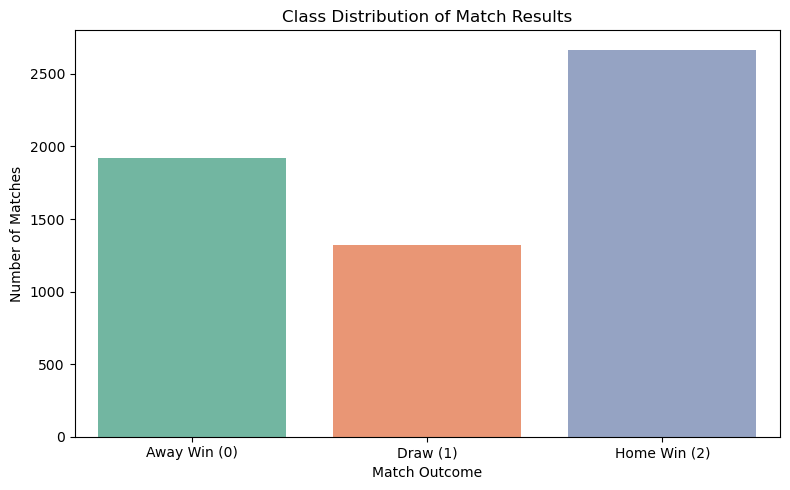

In [329]:
class_counts = euro_matches['result'].value_counts().sort_index()
class_labels = ['Away Win (0)', 'Draw (1)', 'Home Win (2)']

plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=class_counts.values, palette='Set2')
plt.title('Class Distribution of Match Results')
plt.ylabel('Number of Matches')
plt.xlabel('Match Outcome')
plt.tight_layout()
plt.show()

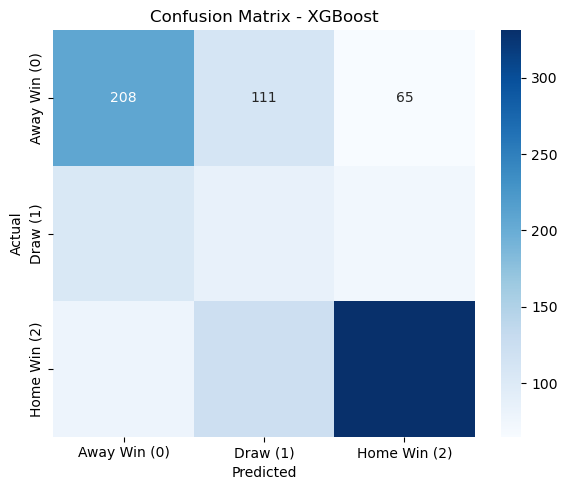

In [331]:
cm = confusion_matrix(y_test, y_pred_xgb)
labels = ['Away Win (0)', 'Draw (1)', 'Home Win (2)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

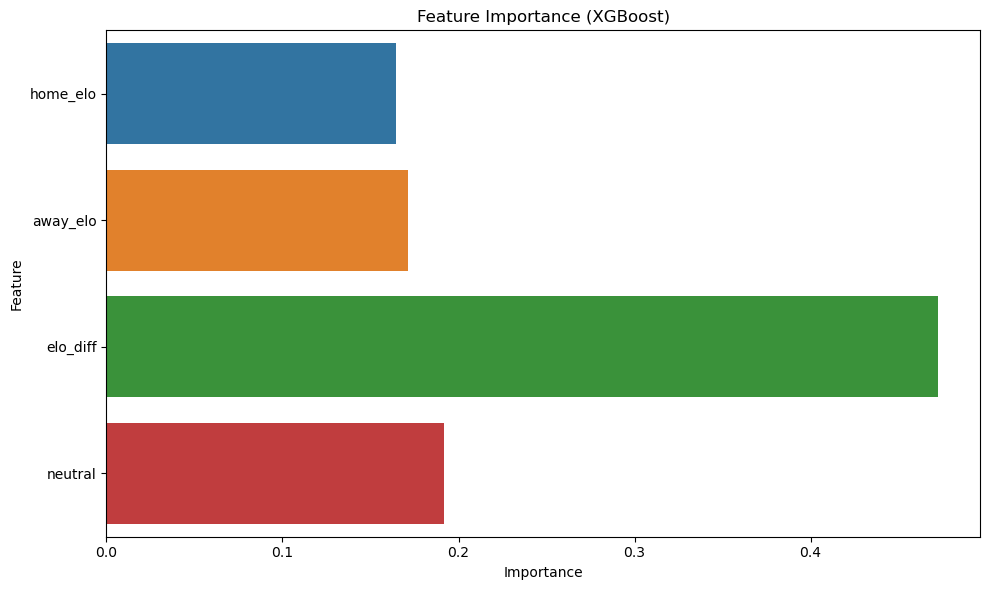

In [333]:
importances = xgb.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()